In [1]:
import pandas as pd
import numpy as np

from pprint import pprint

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import import_ipynb
import algocryptos_preprocessing as alg_preproc
from utils_csa import show_model_accuracy, save_obj, load_obj, evaluate_model, evaluate_model_formated

# from sklearn.metrics import SCORERS
# print(SCORERS.keys())

importing Jupyter notebook from algocryptos_preprocessing.ipynb


In [3]:
dict_hours_labels  = {24:'1d'}
predict_only_one_crypto = True
y_to_be_considered = 'y_+1d_classif'
close_price_increase_targeted = +5
threshold = 0.85
id_cryptocompare_1 = "7605"

dict_df = load_obj('dict_df_2018_12_03_top10')

X_train_1, X_test_1, y_train_1, y_test_1, X_train_close_price_1, X_test_close_price_1 = alg_preproc.get_preprocessed_data(dict_df, dict_hours_labels, 
                                                                     close_price_increase_targeted, 
                                                                     False,
                                                                     do_scale=False, 
                                                                     do_pca=True,
                                                                     id_cryptocompare=id_cryptocompare_1)

In [4]:
#Import libraries:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# TODO : Add test ?
def modelfit(alg, X_, y_, X_test=None, y_test=None, useTrainCV=True, cv_folds=5, early_stopping_rounds=50, metrics='auc'):    
    # Allow to find the best n_estimators parameter
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_, label=y_)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=metrics, early_stopping_rounds=early_stopping_rounds, verbose_eval=False) #verbose_eval=True
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_, y_, eval_metric=metrics)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_)
    dtrain_predprob = alg.predict_proba(X_)[:,1]
        
    #Print model report:
    print("\nModel Report:")
    print("Accuracy (Train): " + str(accuracy_score(y_, dtrain_predictions)))
    print("AUC Score (Train): " + str(roc_auc_score(y_, dtrain_predprob)))
    print("F1 Score (Train): " + str(f1_score(y_, dtrain_predictions)))
    
    if (X_test is not None) and (y_test is not None):
        # Predict testing set:
        dtest_predictions = alg.predict(X_test)
        dtest_predprob = alg.predict_proba(X_test)[:,1]
        
        print("Accuracy (Test): " + str(accuracy_score(y_test, dtest_predictions)))
        print("AUC Score (Test): " + str(roc_auc_score(y_test, dtest_predprob)))
        print("F1 Score (Test): " + str(f1_score(y_test, dtest_predictions)))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()


Model Report:
Accuracy (Train): 0.8220159562107873
AUC Score (Train): 0.9067261655790534
F1 Score (Train): 0.6484074159079898


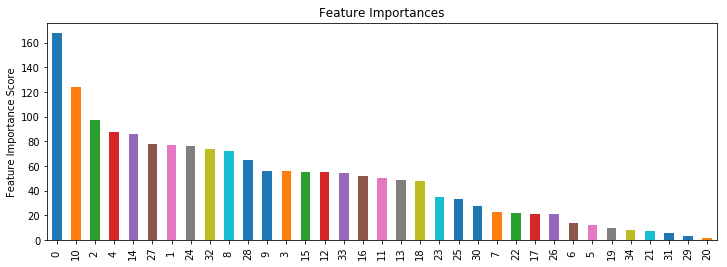

In [5]:
# Step 1: Find the ideal n-estimator param (fail 1000 => use fixed 60)
#scale_pos_weight = y_train_1[y_to_be_considered].value_counts()[False] / y_train_1[y_to_be_considered].value_counts()[True]
scale_pos_weight = 1
xgb1 = XGBClassifier(
            learning_rate =0.1,
            n_estimators=60,
            max_depth=5,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            objective= 'binary:logistic',
            nthread=4,
            scale_pos_weight=scale_pos_weight,
            seed=27)
#modelfit(xgb1, X_train_1, y_train_1[y_to_be_considered], X_test=X_test_1, y_test=y_test_1[y_to_be_considered], metrics='auc')
modelfit(xgb1, X_train_1, y_train_1[y_to_be_considered], useTrainCV=True, metrics='auc')

In [26]:
# Step 2: Tune max_depth and min_child_weight
#scale_pos_weight = y_train_1[y_to_be_considered].value_counts()[False] / y_train_1[y_to_be_considered].value_counts()[True]
scale_pos_weight = 1
n_estimators=60
param_test1 = {
 'max_depth':range(3,15,1),
 'min_child_weight':range(1,6,1)
}

xgb2 = XGBClassifier(
            learning_rate =0.1,
            n_estimators=n_estimators,
            max_depth=5,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            objective= 'binary:logistic',
            nthread=-1,
            scale_pos_weight=scale_pos_weight,
            seed=27)

gsearch2 = GridSearchCV(estimator = xgb2, param_grid = param_test1, scoring='f1',n_jobs=-1,iid=False, cv=5) #scoring='roc_auc'
gsearch2.fit(X_train_1, y_train_1[y_to_be_considered])
print(gsearch2.cv_results_)
print(gsearch2.best_params_)
print(gsearch2.best_score_)

{'mean_fit_time': array([13.44757977, 13.45928893, 13.48396306, 13.54387579, 13.27247329,
       17.54233265, 17.54213142, 17.38883138, 17.1846417 , 17.29388599,
       21.82958407, 21.52224808, 21.75052009, 21.58489585, 21.54889178,
       26.75190868, 26.35924025, 26.07324553, 25.73140178, 25.83270416,
       30.8483582 , 30.93139925, 30.59627419, 30.33635044, 30.56488986,
       36.36386585, 35.77100487, 35.50781879, 34.88068333, 34.96047935,
       41.01308808, 40.19825034, 39.82571783, 39.60559845, 39.57645488,
       46.12983527, 45.2428102 , 45.22726421, 44.20976148, 43.25529823,
       50.83103642, 50.21886601, 49.53699746, 48.42901802, 48.07040195,
       55.91111708, 55.05799179, 54.44356823, 52.83769517, 52.40694656,
       60.06962366, 57.15705361, 55.28903637, 54.87459369, 52.52879033,
       58.12320614, 48.8240767 , 44.56805506, 43.54674101, 40.54818754]), 'std_fit_time': array([0.21574438, 0.34752743, 0.48743699, 0.38878527, 0.06349383,
       0.1662846 , 0.25623414, 0.

In [38]:
# Step 3: Tune gamma
#scale_pos_weight = y_train_1[y_to_be_considered].value_counts()[False] / y_train_1[y_to_be_considered].value_counts()[True]
n_estimators = 60
# max_depth = 3
# min_child_weight = 5

max_depth = 9
min_child_weight = 5

param_test3 = {
 'gamma':[i/10.0 for i in range(0,15)]
}

scale_pos_weight = 1
xgb3 = XGBClassifier(
            learning_rate =0.1,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            objective= 'binary:logistic',
            nthread=-1,
            scale_pos_weight=scale_pos_weight,
            seed=27)

gsearch3 = GridSearchCV(estimator = xgb3, param_grid = param_test3, scoring='f1',n_jobs=-1,iid=False, cv=5) #scoring='roc_auc'
gsearch3.fit(X_train_1, y_train_1[y_to_be_considered])
print(gsearch3.cv_results_)
print(gsearch3.best_params_)
print(gsearch3.best_score_)

{'mean_fit_time': array([ 95.02709069,  98.57027121, 104.14822245, 122.10433955,
       109.5116642 , 114.68294268, 119.13088646, 108.74377298,
       103.8847909 , 108.57463655, 101.36690426,  91.71882496,
        90.46142545,  90.62202864,  91.31011353,  91.43718295,
       111.35053945, 118.08523121, 118.31463628, 116.57391925,
       115.9759758 , 116.05358887,  97.18587346,  80.5311646 ,
        76.94221869,  75.39545798,  73.25430989,  53.84574614,
        36.95452967,  31.77037187]), 'std_fit_time': array([15.69038369,  8.38102567, 18.23426939,  6.63233758, 15.60427028,
       14.86638321,  5.76647341, 15.23052019, 14.04927616, 14.12623903,
       14.41757191,  4.07351747,  4.21690633,  4.37238722,  3.44887472,
        3.59477833, 14.45493903,  5.18860742,  4.87050995,  5.44912037,
        5.46881664,  3.64724462, 12.24915204,  1.1810257 ,  1.06768833,
        0.33075804,  0.78978295, 12.28148016,  1.63638016,  0.90525129]), 'mean_score_time': array([0.11518874, 0.13423543, 0.14

In [41]:
# Step 4: Tune subsample and colsample_bytree
gamma=0.0
n_estimators = 60
max_depth = 9
min_child_weight = 5
scale_pos_weight = 1

param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

scale_pos_weight = 1
xgb4 = XGBClassifier(
            learning_rate =0.1,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=gamma,
            subsample=0.8,
            colsample_bytree=0.8,
            objective= 'binary:logistic',
            nthread=-1,
            scale_pos_weight=scale_pos_weight,
            seed=27)

gsearch4 = GridSearchCV(estimator = xgb4, param_grid = param_test4, scoring='f1',n_jobs=-1,iid=False, cv=5) #scoring='roc_auc'
gsearch4.fit(X_train_1, y_train_1[y_to_be_considered])
print(gsearch4.cv_results_)
print(gsearch4.best_params_)
print(gsearch4.best_score_)

{'mean_fit_time': array([ 95.58443789, 101.3689877 , 100.27387457, 102.98007536,
       101.92709188, 103.20878196,  96.77871027,  90.8192955 ,
        90.51902442,  93.24443192,  94.17460928,  49.18595924,
        32.22277312,  29.38041229,  28.32947707,  27.88754535]), 'std_fit_time': array([ 9.71085642,  2.15635043,  3.91615013,  1.59191222,  3.30353595,
        2.38856544,  4.3449972 ,  4.49012303,  4.60636398,  4.59325912,
        2.83655436, 21.0961219 ,  0.98091309,  0.35023277,  0.73014019,
        0.4329123 ]), 'mean_score_time': array([0.13067141, 0.12314844, 0.09880295, 0.09656687, 0.09753561,
       0.09099422, 0.12155976, 0.14885197, 0.12379966, 0.13632755,
       0.12754283, 0.06072803, 0.0531002 , 0.04349871, 0.03873138,
       0.03536172]), 'std_score_time': array([0.02096514, 0.05183764, 0.02286144, 0.02307991, 0.02312778,
       0.02998021, 0.02702734, 0.02834131, 0.0207829 , 0.03404337,
       0.01482575, 0.02092941, 0.00591274, 0.01103978, 0.01165111,
       0.00989

In [44]:
# Step 5: Tuning Regularization Parameters
gamma=0.0
n_estimators = 60
max_depth = 9
min_child_weight = 5
scale_pos_weight = 1
colsample_bytree= 0.9
subsample= 0.7
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

xgb5 = XGBClassifier(
            learning_rate =0.1,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            objective= 'binary:logistic',
            nthread=-1,
            scale_pos_weight=scale_pos_weight,
            seed=27)

gsearch5 = GridSearchCV(estimator = xgb5, param_grid = param_test5, scoring='f1',n_jobs=-1,iid=False, cv=5) #scoring='roc_auc'
gsearch5.fit(X_train_1, y_train_1[y_to_be_considered])
print(gsearch5.cv_results_)
print(gsearch5.best_params_)
print(gsearch5.best_score_)

{'mean_fit_time': array([23.67035966, 23.92194943, 23.4066267 , 22.89630256, 21.43362117]), 'std_fit_time': array([0.20439089, 0.46648877, 0.51259998, 0.54550377, 0.97218688]), 'mean_score_time': array([0.04188442, 0.0445291 , 0.05079546, 0.06151052, 0.05049777]), 'std_score_time': array([0.0097706 , 0.01077703, 0.01162158, 0.01206165, 0.00717653]), 'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'reg_alpha': 1e-05}, {'reg_alpha': 0.01}, {'reg_alpha': 0.1}, {'reg_alpha': 1}, {'reg_alpha': 100}], 'split0_test_score': array([0.33069836, 0.33166213, 0.33340614, 0.33307743, 0.32885575]), 'split1_test_score': array([0.00596845, 0.0062125 , 0.00709371, 0.00504978, 0.00307561]), 'split2_test_score': array([0.0119596 , 0.01175997, 0.00683149, 0.01072784, 0.00057301]), 'split3_test_score': array([0.02203808, 0.02297835, 0.02246595, 0.02173145, 0.02118644]), 'spli


Model Report:
Accuracy (Train): 0.9146291084660866
AUC Score (Train): 0.9676550841138831
F1 Score (Train): 0.7414676101489504
Accuracy (Test): 0.7429774738224952
AUC Score (Test): 0.7066769633276778
F1 Score (Test): 0.2782118055555556


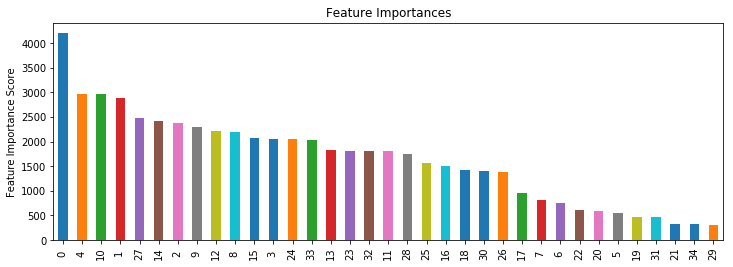

In [49]:
# TEST
n_estimators = 60 * 5 # 60
max_depth = 9
min_child_weight = 5
gamma=0.0
scale_pos_weight = 1
colsample_bytree= 0.9
subsample= 0.7
reg_alpha = 1
learning_rate = 0.01
xgbx = XGBClassifier(
            learning_rate =learning_rate,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            objective= 'binary:logistic',
            nthread=-1,
            scale_pos_weight=scale_pos_weight,
            reg_alpha=reg_alpha,
            seed=27)

modelfit(xgbx, X_train_1, y_train_1[y_to_be_considered], X_test=X_test_1, y_test=y_test_1[y_to_be_considered], useTrainCV=False, metrics='auc')